# Exact GP Regression with Multiple GPUs and Kernel Partitioning
## Introduction
In this notebook, we'll demonstrate training exact GPs on large datasets using two key features from the paper https://arxiv.org/abs/1903.08114: 

1. The ability to distribute the kernel matrix across multiple GPUs, for additional parallelism.
2. Partitioning the kernel into chunks computed on-the-fly when performing each MVM to reduce memory usage.

We'll be using the `protein` dataset, which has about 37000 training examples. The techniques in this notebook can be applied to much larger datasets, but the training time required will depend on the computational resources you have available: both the number of GPUs available and the amount of memory they have (which determines the partition size) have a significant effect on training time.

In [10]:
import math
import torch
import gpytorch
import sys
from matplotlib import pyplot as plt
# sys.path.append('./')
from LBFGS import FullBatchLBFGS

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We will be using the Protein UCI dataset which contains a total of 40000+ data points. The next cell will download this dataset from a Google drive and load it.

In [11]:
import os
import urllib.request
from scipy.io import loadmat
dataset = 'protein'
#if not os.path.isfile(f'./{dataset}.mat'):
#    print(f'Downloading \'{dataset}\' UCI dataset...')
#    urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1nRb8e7qooozXkNghC5eQS0JeywSXGX2S',
#                               f'./{dataset}.mat')
    
data = torch.Tensor(loadmat(f'./{dataset}.mat')['data'])

In [13]:
data

tensor([[ 4.3568e+03,  2.0165e+02, -7.6162e-02,  ..., -4.7975e+01,
         -6.8170e+00, -1.8912e+00],
        [-2.8508e+03, -4.6753e+02,  6.0788e-02,  ..., -4.2975e+01,
         -1.1136e-01,  9.7369e-01],
        [ 4.6787e+03,  5.9385e+02, -5.4212e-02,  ...,  6.9025e+01,
         -7.8412e+00, -5.1343e-01],
        ...,
        [ 2.1139e+03, -8.7306e+02, -1.2349e-01,  ...,  8.0025e+01,
         -4.5575e+00, -9.3838e-01],
        [-3.5833e+03, -1.1741e+03, -9.2719e-03,  ..., -6.2975e+01,
          5.2396e+00,  2.8934e-01],
        [-2.4181e+03, -2.7556e+02,  6.5458e-02,  ..., -2.2975e+01,
          3.3703e+00,  1.0258e+00]])

### Plot the dataset

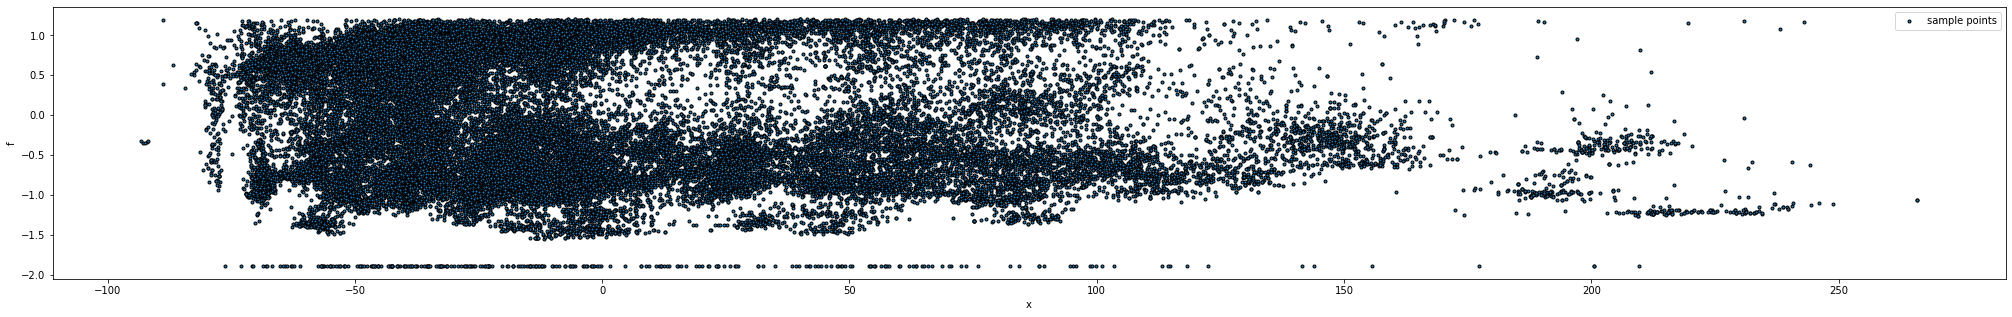

In [18]:
# Setup our figure environment
plt.figure(figsize=(35, 5))

# Plot observations
plt.plot(data[:, 3], data[:, -1], ".", mew=1, linewidth=1, mec="black")

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["sample points"]);

### Normalization and train/test Splits

In the next cell, we split the data 80/20 as train and test, and do some basic z-score feature normalization.

In [3]:
import numpy as np

N = data.shape[0]
# make train/val/test
n_train = int(0.8 * N)
train_x, train_y = data[:n_train, :-1], data[:n_train, -1]
test_x, test_y = data[n_train:, :-1], data[n_train:, -1]

# normalize features
mean = train_x.mean(dim=-2, keepdim=True)
std = train_x.std(dim=-2, keepdim=True) + 1e-6 # prevent dividing by 0
train_x = (train_x - mean) / std
test_x = (test_x - mean) / std

# normalize labels
mean, std = train_y.mean(),train_y.std()
train_y = (train_y - mean) / std
test_y = (test_y - mean) / std

# make continguous
train_x, train_y = train_x.contiguous(), train_y.contiguous()
test_x, test_y = test_x.contiguous(), test_y.contiguous()

output_device = torch.device('cuda:0')

train_x, train_y = train_x.to(output_device), train_y.to(output_device)
test_x, test_y = test_x.to(output_device), test_y.to(output_device)

## How many GPUs do you want to use?

In the next cell, specify the `n_devices` variable to be the number of GPUs you'd like to use. By default, we will use all devices available to us.

In [4]:
n_devices = torch.cuda.device_count()
print('Planning to run on {} GPUs.'.format(n_devices))

Planning to run on 2 GPUs.


In the next cell we define our GP model and training code. For this notebook, the only thing different from the Simple GP tutorials is the use of the `MultiDeviceKernel` to wrap the base covariance module. This allows for the use of multiple GPUs behind the scenes.

In [5]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, n_devices):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        base_covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
        self.covar_module = gpytorch.kernels.MultiDeviceKernel(
            base_covar_module, device_ids=range(n_devices),
            output_device=output_device
        )
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train(train_x,
          train_y,
          n_devices,
          output_device,
          checkpoint_size,
          preconditioner_size,
          n_training_iter,
):
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(output_device)
    model = ExactGPModel(train_x, train_y, likelihood, n_devices).to(output_device)
    model.train()
    likelihood.train()
    
    optimizer = FullBatchLBFGS(model.parameters(), lr=0.1)
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    
    with gpytorch.beta_features.checkpoint_kernel(checkpoint_size), \
         gpytorch.settings.max_preconditioner_size(preconditioner_size):

        def closure():
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            return loss

        loss = closure()
        loss.backward()

        for i in range(n_training_iter):
            options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}
            loss, _, _, _, _, _, _, fail = optimizer.step(options)
            
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, n_training_iter, loss.item(),
                model.covar_module.module.base_kernel.lengthscale.item(),
                model.likelihood.noise.item()
            ))
            
            if fail:
                print('Convergence reached!')
                break
    
    print(f"Finished training on {train_x.size(0)} data points using {n_devices} GPUs.")
    return model, likelihood

## Automatically determining GPU Settings

In the next cell, we automatically determine a roughly reasonable partition or *checkpoint* size that will allow us to train without using more memory than the GPUs available have. Not that this is a coarse estimate of the largest possible checkpoint size, and may be off by as much as a factor of 2. A smarter search here could make up to a 2x performance improvement.

In [6]:
import gc

def find_best_gpu_setting(train_x,
                          train_y,
                          n_devices,
                          output_device,
                          preconditioner_size
):
    N = train_x.size(0)
    
    # Find the optimum partition/checkpoint size by decreasing in powers of 2
    # Start with no partitioning (size = 0)
    settings = [0] + [int(n) for n in np.ceil(N / 2**np.arange(1, np.floor(np.log2(N))))]

    for checkpoint_size in settings:
        print('Number of devices: {} -- Kernel partition size: {}'.format(n_devices, checkpoint_size))
        try:
            # Try a full forward and backward pass with this setting to check memory usage
            _, _ = train(train_x, train_y,
                         n_devices=n_devices, output_device=output_device,
                         checkpoint_size=checkpoint_size,
                         preconditioner_size=preconditioner_size, n_training_iter=1)
            
            # when successful, break out of for-loop and jump to finally block
            break
        except RuntimeError as e:
            print('RuntimeError: {}'.format(e))
        except AttributeError as e:
            print('AttributeError: {}'.format(e))
        finally:
            # handle CUDA OOM error
            gc.collect()
            torch.cuda.empty_cache()
    return checkpoint_size

# Set a large enough preconditioner size to reduce the number of CG iterations run
preconditioner_size = 100
checkpoint_size = find_best_gpu_setting(train_x, train_y,
                                        n_devices=n_devices, 
                                        output_device=output_device,
                                        preconditioner_size=preconditioner_size)

Number of devices: 2 -- Kernel partition size: 0


/home/lgo/dev/kuleuven/thesis-wip/venv/lib/python3.6/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/lgo/dev/kuleuven/thesis-wip/venv/lib/python3.6/site-packages/torch/nn/parallel/parallel_apply.py", line 61, in _worker
    output = module(*input, **kwargs)
  File "/home/lgo/dev/kuleuven/thesis-wip/venv/lib/python3.6/site-packages/gpytorch/kernels/kernel.py", line 398, in __call__
    res = lazify(super(Kernel, self).__call__(x1_, x2_, last_dim_is_batch=last_dim_is_batch, **params))
  File "/home/lgo/dev/kuleuven/thesis-wip/venv/lib/python3.6/site-packages/gpytorch/module.py", line 30, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/home/lgo/dev/kuleuven/thesis-wip/venv/lib/python3.6/site-packages/gpytorch/kernels/scale_kernel.py", line 101, in forward
    return orig_output.mul(outputscales)
RuntimeError: CUDA out of memory. Tried to allocate 2.49 GiB (GPU 0; 7.80 GiB total capacity; 4.99 GiB already allocated; 1.70 GiB free; 5.01 GiB reserved in to

/home/lgo/dev/kuleuven/thesis-wip/venv/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


RuntimeError: CUDA out of memory. Tried to allocate 1.25 GiB (GPU 0; 7.80 GiB total capacity; 6.27 GiB already allocated; 369.06 MiB free; 6.30 GiB reserved in total by PyTorch)
Number of devices: 2 -- Kernel partition size: 9146
Iter 1/1 - Loss: 0.892   lengthscale: 0.490   noise: 0.252
Finished training on 36584 data points using 2 GPUs.


### Training

In [7]:
model, likelihood = train(train_x, train_y,
                          n_devices=n_devices, output_device=output_device,
                          checkpoint_size=10000,
                          preconditioner_size=100,
                          n_training_iter=20)

Iter 1/20 - Loss: 0.892   lengthscale: 0.491   noise: 0.247
Iter 2/20 - Loss: 0.887   lengthscale: 0.425   noise: 0.188
Iter 3/20 - Loss: 0.887   lengthscale: 0.372   noise: 0.162
Iter 4/20 - Loss: 0.869   lengthscale: 0.334   noise: 0.149
Iter 5/20 - Loss: 0.862   lengthscale: 0.318   noise: 0.139
Iter 6/20 - Loss: 0.857   lengthscale: 0.293   noise: 0.121
Iter 7/20 - Loss: 0.858   lengthscale: 0.293   noise: 0.121
Convergence reached!
Finished training on 36584 data points using 2 GPUs.


## Computing test time caches

In [8]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.beta_features.checkpoint_kernel(1000):
    # Make predictions on a small number of test points to get the test time caches computed
    latent_pred = model(test_x[:2, :])
    del latent_pred  # We don't care about these predictions, we really just want the caches.

### Testing: Computing predictions

In [9]:
with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.beta_features.checkpoint_kernel(1000):
    %time latent_pred = model(test_x)
    
test_rmse = torch.sqrt(torch.mean(torch.pow(latent_pred.mean - test_y, 2)))
print(f"Test RMSE: {test_rmse.item()}")

CPU times: user 92.5 ms, sys: 17 ms, total: 109 ms
Wall time: 99.4 ms
Test RMSE: 0.5483576655387878
